Experiment 1 with resnet18 transfer learning
============================================

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from utils import *
from classes import *
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()

# load memory profiler
%load_ext memory_profiler


print('main imports complete')

main imports complete


In [2]:
# Create custom Dataset object
# A unique object will need to be created for each book.
# It will take in all the transforms = a dict with key, val where:
#   key=phase, val=tranform to use

# To create custom Dataset
from torch.utils.data.dataset import Dataset
from torchvision.datasets.folder import find_classes, make_dataset, IMG_EXTENSIONS, default_loader

class BookDatasetContainer:
    pass

class BookDataset:
    pass

class BookDatasetContainer:
    __samples = None
    __images = []
    
    def __init__(self, root, loader=default_loader):
        # Read in all images
        classes, class_to_idx = find_classes(root)
        self.__samples = make_dataset(root, class_to_idx, IMG_EXTENSIONS)
        self.__images = [(loader(path), target) for path, target in self.__samples]
            
    def __len__(self):
        return len(self.__samples)
    
    def __getitem__(self, index):
        return self.__images[index]
    
    # Method of BookDatasetContainer to create a BookDataset with a specific transform
    def create_dataset(self, transform):
        return BookDataset(self, transform)
    
# BookDataset class uses the BookDatasetContainer's images, adding transform functionality
class BookDataset(Dataset):
    __dataset_container = None
    __transform = None

    def __init__(self, dataset_container, transform):
        self.__dataset_container = dataset_container
        self.__transform = transform

    def __getitem__(self, index):
        sample, target = self.__dataset_container[index]
        if (self.__transform is not None):
            sample = self.__transform(sample)
        return sample, target

    def __len__(self):
        return len(self.__dataset_container)

In [3]:
# ========================================
# Step 1. define data transform
#
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':
print("Set up data transforms.")
img_input_size = 56

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # RandomRotation does not seem to be working on Windows right now
        transforms.RandomRotation(45),

        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
        transforms.RandomGrayscale(p=0.1),

        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
}

# Data augmentation and normalization for training
# Just normalization for validation
net1_data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

# data_transforms = selected_transforms
data_transforms = net1_data_transforms


Set up data transforms.


In [4]:
# ========================================
# Step 2. define and load data
#
# TODO: Suggest not using data loader to load the images. Because it is slow. Every epochs, you load the 
# image data again to the RAM and then from RAM to GPU RAM. That takes a lot of time. Since the images are 
# <1GB, you can preload the images into RAM first, that will make you training way faster. 

# Note: you only has about 200MB of images, it's small. It should not take much time to load!
# ========================================

# This flag is on if the custom dataset BookDataset should be used
use_custom_dataset = False

# Need the __name__ check to make multiprocessing work on Windows for some reason
# Unfortunately, still getting broken pipe error on Windows with custom dataset.
# if __name__ == '__main__':

print("Create dataset and dataloader")

# hyperparameter
# batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster
batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster

# data location
#     book_data_dir = "/home/kcho/clab_data/"
#     book_data_dir = "C:\\Users\\rahul\\Documents\\work\\BuildUCLA\\data\\printed_with_ids_harsh_filter\\books-preprocessed-images"
book_data_dir = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images'
set_types = ['train', 'val', 'test']

# test books are currently arbitrarily set
test_books = set(["Albin", "Dryden"])

# Get the list of all books in the data set
books_in_data = set([b for b in os.listdir(book_data_dir)
                 if os.path.isdir(os.path.join(book_data_dir, b))])

if use_custom_dataset:
    print('Using custom dataset.')
    book_data_sets = {b : BookDatasetContainer(os.path.join(book_data_dir, b))
                      for b in books_in_data}
    book_data_loaders = {b : {t : torch.utils.data.DataLoader(
                              book_data_sets[b].create_dataset(data_transforms[t]),
        batch_size=batch_size,
        shuffle=True, # make sure you shuffle the data
        num_workers=4)
                              for t in set_types}
                         for b in books_in_data}

else:
    print('Using default ImageFolder dataset.')
    book_data_sets = {b : {t : datasets.ImageFolder(os.path.join(book_data_dir, b), 
                                                    transform = data_transforms[t])#, transform=test_transform)
                          for t in set_types}
                     for b in books_in_data}


    # create a dict of dataloaders, book_data_loaders['Albin']['train']
    book_data_loaders = {b : {t : torch.utils.data.DataLoader(book_data_sets[b][t],
                                                              batch_size=batch_size,
                                                              shuffle=True, # make sure you shuffle the data
                                                              num_workers=4)
                              for t in set_types}
                         for b in books_in_data}


print("data loading complete")



Create dataset and dataloader
Using default ImageFolder dataset.
data loading complete


(1, 224, 224)
(224, 224)


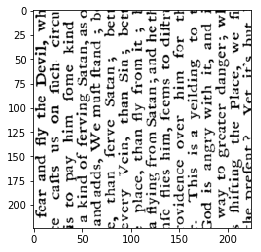

In [5]:
# 
# ========================================
# Check your data to make sure it is correct
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':

for data in book_data_loaders['Defoe']['train']:
    # get the inputs
    inputs, labels = data

    # plot to verify the input is correct
    input1 = inputs[0].numpy()
    print(input1.shape)
    input1 = np.swapaxes(input1,0,2).squeeze()
    print(input1.shape)
    plt.imshow(input1,cmap='gray')

    break

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class JQNet1(nn.Module):
    def __init__(self):
        super(JQNet1, self).__init__()
        if use_gpu:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cuda()
            self.fc2 = nn.Linear(64, 25).cuda()
            self.fc3 = nn.Linear(25,2).cuda()
        else:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cpu()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cpu()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cpu()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cpu()
            self.fc2 = nn.Linear(64, 25).cpu()
            self.fc3 = nn.Linear(25,2).cpu()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [7]:
# ========================================
# Step 3. define model structure
#
# TODO: Stick with MNIST for now because it is smaller network and faster to train. Note that you lose
# a lot of inofmration when yo udownsample the image to 28x28. THat's okay, you optimize other parts first, e.g.,
# data loading before you optimize your model.
# ========================================
from lib.playground.utee import selector
from lib.playground.mnist import model
import os

def create_model_architecture(model_type='mnist'):
    """
    params model_type: the type of model, for now, support mnist and resnet18    
    """
    if model_type == 'mnist':
        print('using pretrained mnist model')
        
        # load the model from the playground library
        model_annotation, ds_fetcher, is_imagenet = selector.select('mnist')
        
        # remove last layer
        removed = list(model_annotation.model.children())[:-1]
        
        # add a front layer to account for new input
        # IMPORTANT, we need to update the self.input_dims of the MLP class
        removed = [nn.Linear(img_input_size*img_input_size,28*28), nn.ReLU()] + removed
        
        # formulate the layers
        model_annotation.model=torch.nn.Sequential(*removed)
        
        # add the new fc layer
        model_annotation.model.fc = torch.nn.Linear(256,2).cuda()
        
        # update the self.input_dims of the network
        model_annotation.input_dims = img_input_size * img_input_size                

    elif model_type == 'resnet18':    
        print("Transferring resnet18 and retraining with annotations dataset.")    
        model_annotation = models.resnet18(pretrained=True)
        num_params = sum(1 for i in model_annotation.parameters())

        # There are 10 layers (model_ft.children()) in resnet18
        # Freezing the first half of resnet18, freezing all params for layers 1-5
        max_layer = 5
        curr_layer = 1
        last_layer = None
        for child in model_annotation.children():
            if curr_layer <= max_layer:
                for param in child.parameters():
                    param.requires_grad = False
                last_layer = child
                curr_layer = curr_layer + 1
            else:
                break

        # Replace the final fully connected layer to perform binary classification
        num_ftrs = model_annotation.fc.in_features
        model_annotation.fc = nn.Linear(num_ftrs, 2)
        
    elif model_type == 'jq_net1':
        print("Creating JQ's net1.")
        use_gpu = False
        model_annotation = JQNet1()
        

    # return
    if use_gpu:
        return model_annotation.cuda()
    else:
        return model_annotation.cpu()


In [ ]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================

def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):
    since = time.time()

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # looping parameters
        running_loss = 0.0
        confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'val']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # Iterate over each book
            running_loss = 0.0
            confusion_matrix = tnt.meter.ConfusionMeter(2)
#             for book in tqdm_notebook(data_loaders[phase]): 
            for book in data_loaders[phase]:
                for data in data_loaders[phase][book]:
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # back
                    if phase == 'train': 
                        loss.backward()
                        optimizer.step()

                    # Add to confusion matrix
                    confusion_matrix.add(outputs.data, labels.data)

                    # statistics
                    running_loss += loss.data[0] * inputs.size(0) 
            
            # report evaluation
            print('Phase:%s' %phase)
            print('Confusion matrix:\n', confusion_matrix.conf)
            print('validation loss', running_loss)
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return model

In [ ]:
# ========================================
# Step 5. execute the train process
# ========================================

# overriding to use CPU when GPU is busy
use_gpu = False

# get the model
# model = create_model_architecture()
model = create_model_architecture('jq_net1')

# train parameters
# num_training_epochs = 5
num_training_epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
earlyStoppingCriteria = EarlyStopping(min_delta = 1e-4, patience=5)

# dataloader parameters
cross_val_loaders = {}

# leave-one-book-out cross validation
for val_book in books_in_data:
    
    # define the train and validation loaders
    train_books = books_in_data - set([val_book])    
    cross_val_loaders["train"] = {b : book_data_loaders[b]["train"] for b in train_books}
    cross_val_loaders["val"] = {b : book_data_loaders[b]["val"] for b in [val_book]}

    # train
    trained_model = train(model,
                          criterion,
                          optimizer,
                          cross_val_loaders,
                          num_epochs=num_training_epochs)
    
    # remove the break as needed
#     break

print("training complete")

Creating JQ's net1.
Epoch 0/49
----------


/usr/lib/python3/dist-packages/ipykernel_launcher.py:60: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Phase:train
Confusion matrix:
 [[ 206  448]
 [ 640 1188]]
validation loss tensor(1756.1359)
Phase:val
Confusion matrix:
 [[  0 107]
 [  0 229]]
validation loss tensor(210.3535)
Epoch 1/49
----------
Phase:train
Confusion matrix:
 [[  50  604]
 [ 152 1676]]
validation loss tensor(1659.4476)
Phase:val
Confusion matrix:
 [[  0 107]
 [  0 229]]
validation loss tensor(215.3496)
Epoch 2/49
----------
Phase:train
Confusion matrix:
 [[   9  645]
 [  24 1804]]
validation loss tensor(1606.1172)
Phase:val
Confusion matrix:
 [[  0 107]
 [  0 229]]
validation loss tensor(214.8951)
Epoch 3/49
----------
Phase:train
Confusion matrix:
 [[   2  652]
 [   9 1819]]
validation loss tensor(1613.9127)
Phase:val
Confusion matrix:
 [[  0 107]
 [  0 229]]
validation loss tensor(214.1914)
Epoch 4/49
----------
Phase:train
Confusion matrix:
 [[   1  653]
 [   1 1827]]
validation loss tensor(1486.3921)
Phase:val
Confusion matrix:
 [[  0 107]
 [  0 229]]
validation loss tensor(211.7924)
Epoch 5/49
----------
Phase